# <center>Team ZF1 Movie Recommendation 2022 Challenge</center>

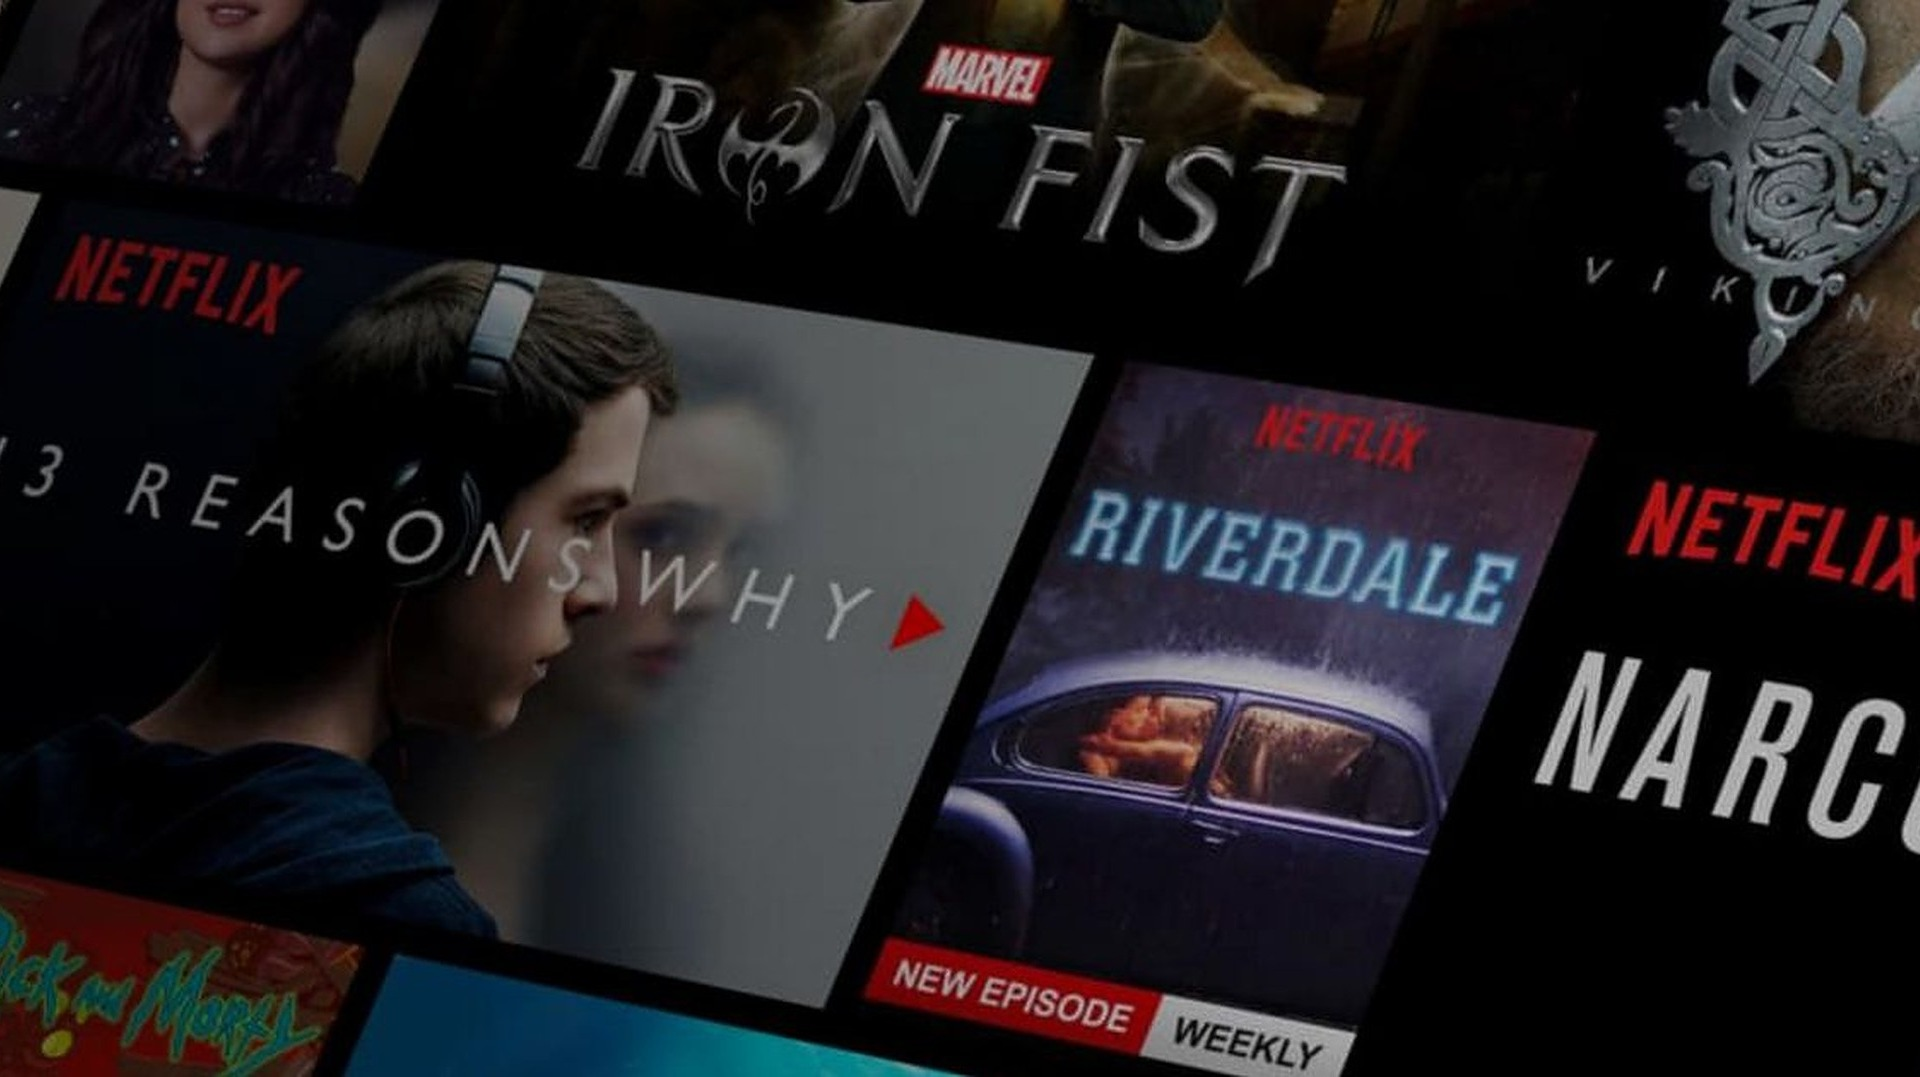

<a id='Table_Contents'></a><br>
### Table of Contents
1. [Introduction](#intro)
 * Problem Statement
 
2. [Data](#imports_data)
 * Running Experiment on Comet
 * Importing Packages
 * Loading Data
 * Dataset Description
 * Checking for Missing Values
 
3. [Exploratory Data Analysis](#EDA)
 * Movie Genres 
 * Movie Ratings
 * Movies Released Per Year
 * IMDB Data

4. [Model Building](#model)
 * Content Based Filtering
 * Collaborative Filtering
 * Similarity Measure
 * Recommender System Building
 * Model Selection
 




<a id='intro'></a><br>
## 1. Introduction
[Back to Table of Contents](#Table_Contents)

### Problem Statement

In today’s technology driven world, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

The aim of this project is to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being personalised recommendations - generating platform affinity for the streaming services which best facilitates their audience's viewing.




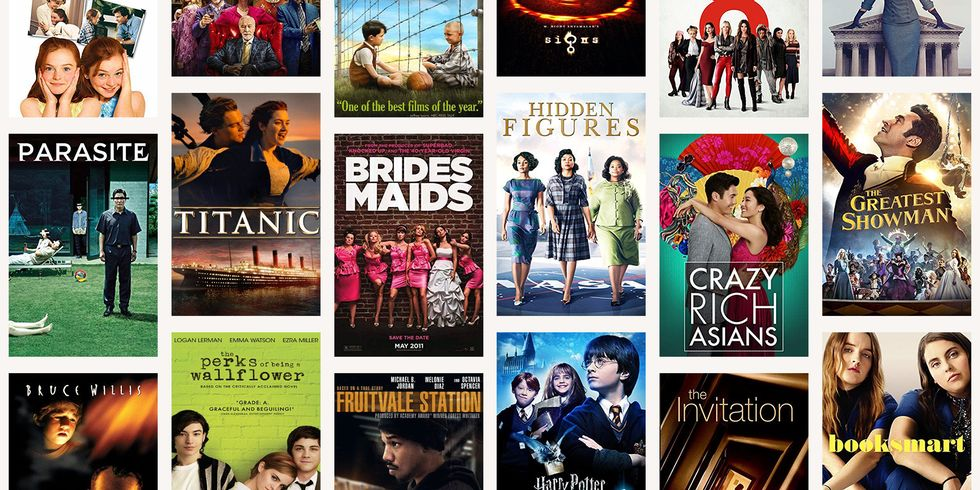

<a id='imports_data'></a><br>
## 2. Data
[Back to Table of Contents](#Table_Contents)

### Running Experiment on Comet

In [13]:
# import comet_ml 
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="mn7gOjsbMtlJODxIBDP2G0w6e",
    project_name="movie-recommendation-edsa-teamzf1",
    workspace="roceey",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/roceey/movie-recommendation-edsa-teamzf1/a55aaa1a03fd4423b23d5317528a6fe7



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Packages

In [1]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display_html 
from IPython.core.display import HTML
from collections import defaultdict
import datetime
import re
import squarify
import os
from plotly.offline import init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as pyo
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)



# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate, train_test_split
from surprise import SVD,accuracy
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Loading Data

We first load the data and inspect its head.

In [2]:
#data_folder = '/kaggle/input/edsa-movie-recommendation-2022/'
data_folder = 'C:/Users/Hudson/Documents/Unsupervised_learning/'

df_train = pd.read_csv(data_folder + 'train.csv')
df_test = pd.read_csv(data_folder + 'test.csv')
df_tags = pd.read_csv(data_folder + 'tags.csv')
df_movies = pd.read_csv(data_folder + 'movies.csv')
df_links = pd.read_csv(data_folder + 'links.csv')
df_imdb = pd.read_csv(data_folder + 'imdb_data.csv')
df_genome_scores = pd.read_csv(data_folder + 'genome_scores.csv')
df_genome_tags = pd.read_csv(data_folder + 'genome_tags.csv')
df_sample_submission = pd.read_csv(data_folder + 'sample_submission.csv')


In [4]:
# Show "imdb_df" dataframe
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [6]:
# Function that displays multiple dataframes in one cell
def data_overview(dataframe_list, column_names=[]):

    html_string = ''
    html_string += ('<tr>' + ''.join(f'<td style="text-align:center">{name}</td>' for name in column_names) + '</tr>')
    html_string += ('<tr>' + ''.join(f'<td style="vertical-align:top"> {df.to_html(index=True)}</td>' for df in dataframe_list)
                    +'</tr>')
    html_string = f'<table>{html_string}</table>'
    html_string = html_string.replace('table','table style="display:inline"')
    display_html(html_string, raw=True)  

In [7]:
# Display the overview of train, test, links and tags dataframes
data_overview([df_train.head(), df_test.head(), df_links.head(), df_tags.head()], 
              column_names=['Train','Test','Links','Tags'])

Train Test Links Tags 
 
 
 
 userId 
 movieId 
 rating 
 timestamp 
 
 
 
 
 0 
 5163 
 57669 
 4.0 
 1518349992 
 
 
 1 
 106343 
 5 
 4.5 
 1206238739 
 
 
 2 
 146790 
 5459 
 5.0 
 1076215539 
 
 
 3 
 106362 
 32296 
 2.0 
 1423042565 
 
 
 4 
 9041 
 366 
 3.0 
 833375837 
 
 
 
 
 
 
 userId 
 movieId 
 
 
 
 
 0 
 1 
 2011 
 
 
 1 
 1 
 4144 
 
 
 2 
 1 
 5767 
 
 
 3 
 1 
 6711 
 
 
 4 
 1 
 7318 
 
 
 
 
 
 
 movieId 
 imdbId 
 tmdbId 
 
 
 
 
 0 
 1 
 114709 
 862.0 
 
 
 1 
 2 
 113497 
 8844.0 
 
 
 2 
 3 
 113228 
 15602.0 
 
 
 3 
 4 
 114885 
 31357.0 
 
 
 4 
 5 
 113041 
 11862.0 
 
 
 
 
 
 
 userId 
 movieId 
 tag 
 timestamp 
 
 
 
 
 0 
 3 
 260 
 classic 
 1439472355 
 
 
 1 
 3 
 260 
 sci-fi 
 1439472256 
 
 
 2 
 4 
 1732 
 dark comedy 
 1573943598 
 
 
 3 
 4 
 1732 
 great dialogue 
 1573943604 
 
 
 4 
 4 
 7569 
 so bad it's good 
 1573943455

In [8]:
# Display the overview of movies, genome_tags and genome_scores dataframes
data_overview([df_movies.head(), df_genome_tags.head(), df_genome_scores.head()], 
                      column_names=['Movies','Genome Tags','Genome Scores'])

Movies Genome Tags Genome Scores 
 
 
 
 movieId 
 title 
 genres 
 
 
 
 
 0 
 1 
 Toy Story (1995) 
 Adventure|Animation|Children|Comedy|Fantasy 
 
 
 1 
 2 
 Jumanji (1995) 
 Adventure|Children|Fantasy 
 
 
 2 
 3 
 Grumpier Old Men (1995) 
 Comedy|Romance 
 
 
 3 
 4 
 Waiting to Exhale (1995) 
 Comedy|Drama|Romance 
 
 
 4 
 5 
 Father of the Bride Part II (1995) 
 Comedy 
 
 
 
 
 
 
 tagId 
 tag 
 
 
 
 
 0 
 1 
 007 
 
 
 1 
 2 
 007 (series) 
 
 
 2 
 3 
 18th century 
 
 
 3 
 4 
 1920s 
 
 
 4 
 5 
 1930s 
 
 
 
 
 
 
 movieId 
 tagId 
 relevance 
 
 
 
 
 0 
 1 
 1 
 0.02875 
 
 
 1 
 1 
 2 
 0.02375 
 
 
 2 
 1 
 3 
 0.06250 
 
 
 3 
 1 
 4 
 0.07575 
 
 
 4 
 1 
 5 
 0.14075

### Dataset Description 

The supplied dataset comprises the following:

* train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.
* test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
* tags.csv - User assigned for the movies within the dataset.
* movies.csv - Contains a database of movies categorized into different genres.
* genome_scores.csv - A score mapping the strength between movies and tag-related properties.
* genome_tags.csv - User assigned tags for genome-related scores.
* imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
* links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.

Below is additional information regarding the various datasets:

#### Ratings Data File Structure (train.csv)
Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

#### Tags Data File Structure (tags.csv)
Each line of this file after the header row represents one tag applied to one movie by one user.
Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag are determined by each user.

#### Movies Data File Structure (movies.csv)
Genres are a pipe-separated list, and include Action, Adventure, Animation, Children's, Comedy, Crime, Documentary,
Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western.

#### Links Data File Structure (links.csv)
Identifiers that can be used to link to other sources of movie data are contained in the file links.csv. 

#### Tag Genome (genome-scores.csv and genome-tags.csv)
The tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). 


### Checking for Missing Values

In [32]:
df_train.isnull().sum()


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [33]:
df_test.isnull().sum()


userId     0
movieId    0
dtype: int64

In [36]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [40]:
df_imdb.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

In [35]:
df_genome_scores.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

In [37]:
df_genome_tags.isnull().sum()

tagId    0
tag      0
dtype: int64

In [38]:
df_links.isnull().sum()

movieId      0
imdbId       0
tmdbId     107
dtype: int64

In [39]:
df_tags.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

#### Observations
- The `links` dataset has 107 missing values in the `tmdbId` column. 
This makes up for only 0.17% of the column data.
- The `tags` dataset has 16 missing values in the `tag` column. This makes up for only 0.00015% of the data.
- The `imdb_data` dataset has a range of missing values. This is analysed further below.

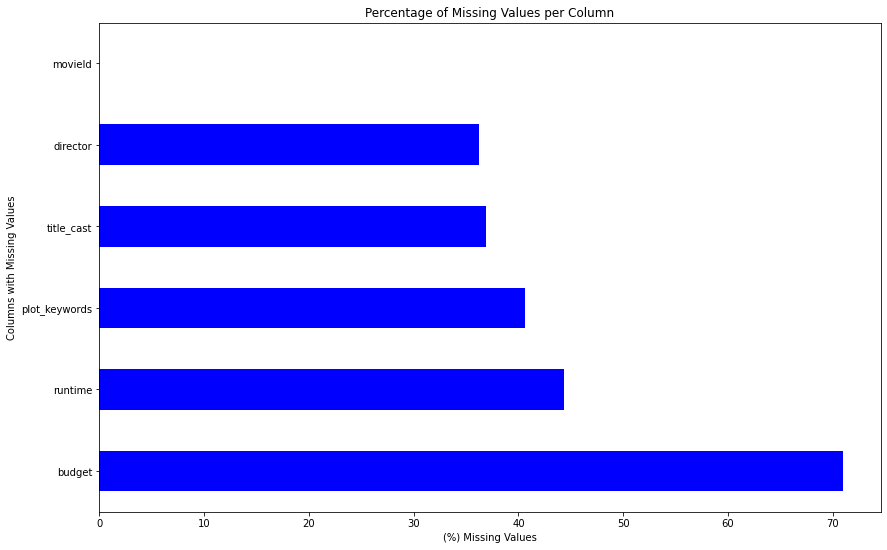

In [10]:
# The percentage of each column of missing values in the IMDB dataset
total = df_imdb.isnull().sum().sort_values(ascending=False)
percent_1 = df_imdb.isnull().sum()/df_imdb.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2],
                         axis=1, keys=['Total', '(%) missing'])
missing_data['(%) missing'].plot(kind='barh', color='blue')
plt.rcParams["figure.figsize"] = (14,7)
plt.xlabel('(%) Missing Values')
plt.ylabel('Columns with Missing Values')
plt.title('Percentage of Missing Values per Column')
plt.show()

<a id='EDA'></a><br>
## 3. Exploratory Data Analysis
[Back to Table of Contents](#Table_Contents)

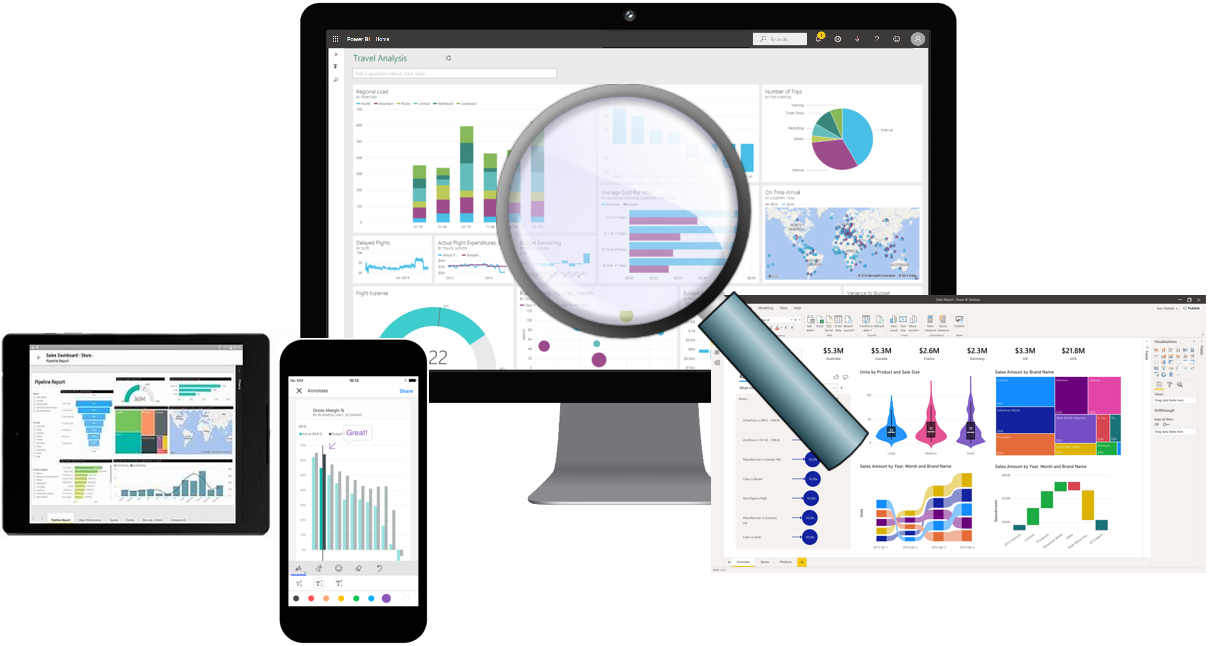

In this section we perform exploratory data analysis on the data to gain a better understanding of the features and the relationships between them. We will employ both statistical and visualisation methods of EDA.

### Movie Genres

We start by conducting an analysis of the movies dataframe to find out the most and least common genres. 

#### Movie Genre Wordcloud

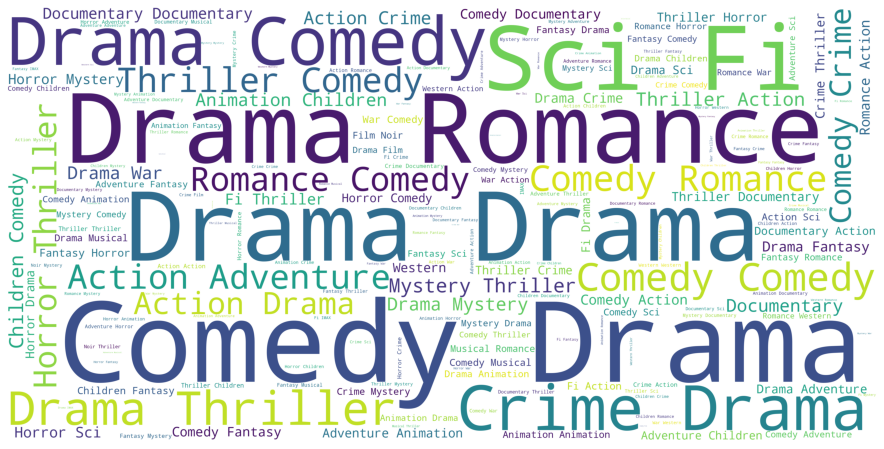

In [19]:
# Looking at the titles and checking for any similarity
df_movies['genres'] = df_movies['genres'].astype('str')
genre_corpus = ' '.join(df_movies['genres'])
#Generating the stopwords
stopword = ['no genres', 'no', 'genres', 'genre', 'listed']
# Generating the wordcolud
genre_wordcloud = WordCloud(stopwords=stopword, background_color='white', height=2000, width=4000).generate(genre_corpus)
plt.figure(figsize=(16,8))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

In [21]:
# Top 10 genres by volume:
df_genres = df_movies["genres"].value_counts()
df_genres.head(10)

Drama                   9056
Comedy                  5674
(no genres listed)      5062
Documentary             4731
Comedy|Drama            2386
Drama|Romance           2126
Horror                  1661
Comedy|Romance          1577
Comedy|Drama|Romance    1044
Drama|Thriller           933
Name: genres, dtype: int64

In [4]:
# Bottom 10 genres by volume:
df_genres = df_movies["genres"].value_counts()
df_genres.tail(10)

Action|Adventure|Fantasy|Romance|IMAX               1
Crime|Drama|Thriller|Western                        1
Fantasy|Romance|Thriller|IMAX                       1
Adventure|Fantasy|Horror|Romance|Sci-Fi|Thriller    1
Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX     1
Action|Adventure|Crime|Fantasy                      1
Drama|Film-Noir|Musical|Thriller                    1
Action|Drama|Horror|Mystery                         1
Adventure|Comedy|Sci-Fi|Thriller|War                1
Comedy|Horror|Mystery|Sci-Fi|Western                1
Name: genres, dtype: int64

Interestingly, we observe that the top genres by volume only have one or two genre types, whereas the bottom genres consist of multiple genres. This is probably because these movies are a lot more niche and uncommon, resulting in a lower volume in the dataset.


Next we plot the individual genres from the most common to the least common.

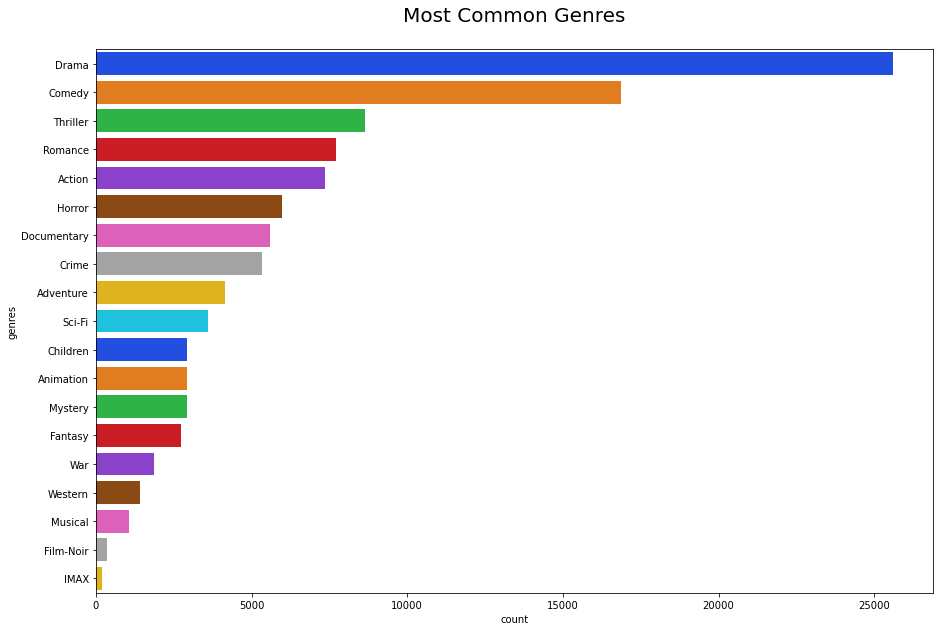

In [12]:
# Create dataframe containing only the movieId and genres

movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])
movies_genres = movies_genres[movies_genres.genres != '(no genres listed)']
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most Common Genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='bright')
plt.show()

### Movie Ratings

Next we inspect the train dataframe which consists of ratings data.

#### Movie Ratings Distribution
We investigate how ratings, which range from 0 to 5 with 0.5 increments, are distributed in the movies data.

In [8]:
# Ratings distribution
data = df_train['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in 
                       (data.values / df_train.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = ['aliceblue']),
               y = data.values
               )
# Create layout
layout = dict(title = 'Distribution of Movie Ratings'.format(df_train.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

From the figure above we observe that 4.0 is the most commonly score, with 26.5% of the movies in the dataframe assigned that score. This could be explained by the fact that users tend to only rate movies they enjoyed and avoid rating movies they dont like. If a user doesn't enjoy a movie, it is quite unlikely that they will watch it up until the end and rate it. This is why there are few low ratings as compared to high ratings.

We also observe that half scores (0.5, 1.5, 2.5, 3.5 and 4.5) are less commonly used than integer score values. We don't know if this is because users prefer to rate movies with integer values or if it's because half scores were introduced after the original scoring system was already in use, leading to a decreased volume in a dataset with ratings from 1995. 

#### Top Rated Movies

In [7]:
def popular_movies(df1,df2):
    
    """
    A function that returns popular movies based on the average ratings.
    
    """
   
   
    rating = pd.DataFrame(df1.groupby('movieId')['rating'].mean())
    
    rating['ratings_count'] = pd.DataFrame(df1.groupby('movieId')['rating'].count())
    rating=rating.sort_values(by=['ratings_count','ratings_count'],ascending=False).reset_index()
    
    
    inner_join = pd.merge(rating,df2,on ='movieId',how ='inner')
    popular_movies = inner_join[['title','rating','ratings_count']].rename(columns={"rating": "rating"})
    
    return popular_movies

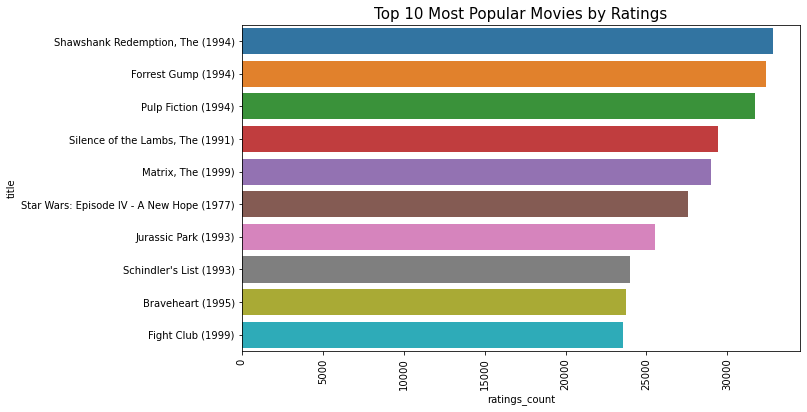

In [8]:
# Top 10 most popular movies
df = popular_movies(df_train, df_movies)


plt.figure(figsize = (10,6))#Bar plot of most popular movies by ratings
ax=sns.barplot(y='title', x='ratings_count', data=df.head(10))
ax.set_title('Top 10 Most Popular Movies by Ratings',fontsize=15)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

From the above plot we observe that the most poular movie of all time is Shawshank Redemption that was released in 1994 and that has an average rating of approximately 4.42. 

#### Number of Ratings per Movie
We explore how many movies receive a number of ratings and visualize this in a plot.

In [9]:
# Number of ratings per movie
data = df_train.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution of Number of Ratings Per Movie',
                   xaxis = dict(title = 'Number of Ratings Per movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We observe that the count of number of ratings per movie is on a decreasing scale.

#### Ratings Per Day of Week

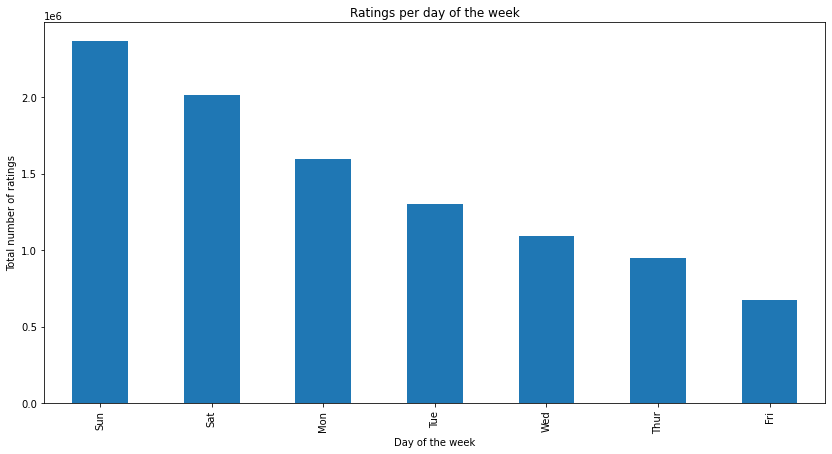

In [16]:
# Convert timestamp to datetime
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], unit='ms')

# Extract the days of the week from the timestamp column
df_train['day_of_week'] = df_train['timestamp'].dt.dayofweek
days = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
df_train['day_of_week'] = df_train['day_of_week'].apply(lambda x: days[x])

# Plot of the total number of ratings for each day
df_train['day_of_week'].value_counts().plot(kind='bar')
plt.title('Ratings per day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Total number of ratings')
plt.show()

We observe that most ratings happen on Sunday with the least happening on Friday

#### Rating Per Movie Genre

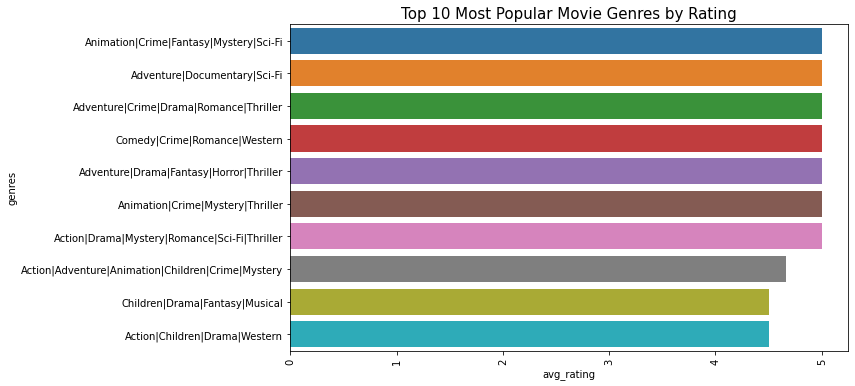

In [46]:
combined_df = pd.merge(df_train, df_movies, on="movieId", how="left")

# Top 10 Rated Movie Genres
genre_ratings = (
    combined_df[["genres", "rating"]]
    .groupby(["genres"])
    .agg(["mean"])
    .sort_values(by=[("rating", "mean")], ascending=False)
)
genre_ratings.reset_index(inplace=True)
genre_ratings['avg_rating'] = genre_ratings[("rating", "mean")]
plt.figure(figsize = (10,6))#Bar plot of most popular movies by ratings
ax=sns.barplot(y='genres', x='avg_rating', data=genre_ratings.head(10))
ax.set_title('Top 10 Most Popular Movie Genres by Rating',fontsize=15)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()


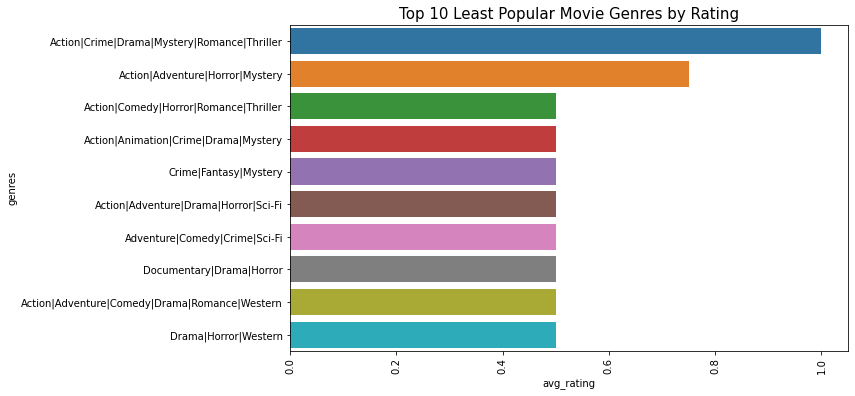

In [48]:
# Top 10 Least Popular Movie Genres by Ratings
plt.figure(figsize = (10,6))#Bar plot of most popular movies by ratings
ax=sns.barplot(y='genres', x='avg_rating', data=genre_ratings.tail(10))
ax.set_title('Top 10 Least Popular Movie Genres by Rating',fontsize=15)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

#### Top Users by Number of Ratings

In [3]:
def user_ratings_count(df, n):
    """
    Counts the number of user ratings.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        n (int): number of users to show
    Returns
    -------
        barplot (NoneType): barplot of top n users by number of observations
    Example
    -------
        >>> df = pd.DataFrame({'userId':[1,2,3,1,2,4,5,4]})
        >>> user_ratings_count(df, 3)
            NoneType (barplot)
    """
    plt.figure(figsize=(8,6))
    data = df['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index, palette='brg', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df['movieId'].nunique())
    plt.show()

Combined number of ratings:	 38970 
Total number of movies:		 48213


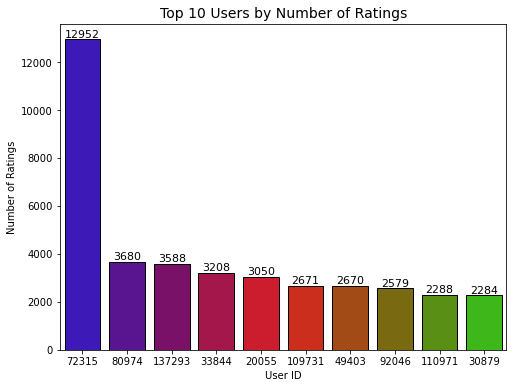

In [4]:
user_ratings_count(df_train,10)

The figure above shows that user 72315 has rated an extreme number of movies relative to other users. This user can therefore be regarded as an outlier.

### Movies Released Per Year

We explore how many movies have been released per year using the movies dataset.

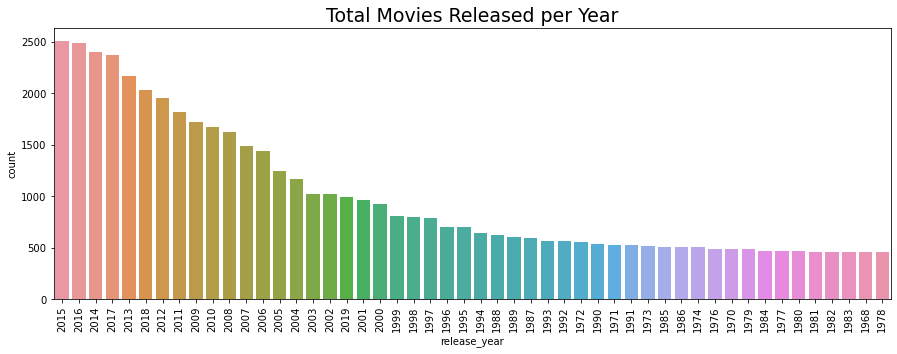

In [17]:
# Total movies released in each year using a count plot.
df_movies['release_year'] = df_movies['title'].str[-5:-1]
figure= plt.subplots(figsize=(15, 5))
axes=sns.countplot(x = df_movies['release_year'], order = df_movies['release_year'].value_counts()[0:50].index)
axes.set_title('Total Movies Released per Year',fontsize=19)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

We observe that as the years progress, the amount of movies being released have significantly increased with the most movies released in 2015 and 2016. The number of movies being released per year have definitely shot up since the year 2000.

### IMDB Data

Here we explore the IMBD data to learn more about the content of the movies and the people who worked on them.

#### Top Actors by Volume

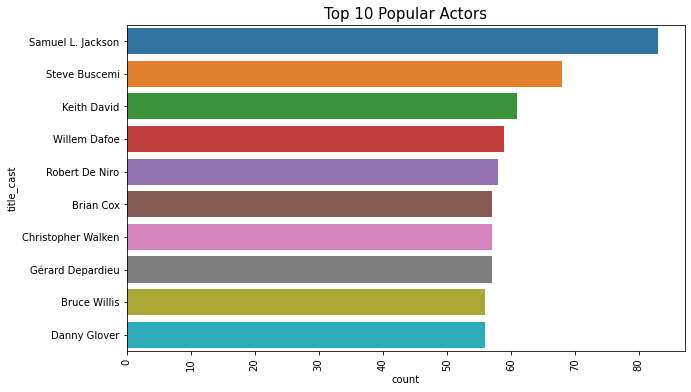

In [23]:
df_imdb_copy = df_imdb.copy()
df_imdb_copy['title_cast']=df_imdb_copy['title_cast'].str.split('|') #spliting the title cast into a list
df_imdb_copy['plot_keywords']=df_imdb_copy['plot_keywords'].str.split('|') #spliting the Key words into a list
plt.figure(figsize = (10,6))
title_cast = df_imdb_copy['title_cast'].explode()
ax=sns.countplot(y=title_cast, order = title_cast.value_counts().index[:10])
ax.set_title('Top 10 Popular Actors',fontsize=15)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

#### Top 10 Most Popular Movie Directors

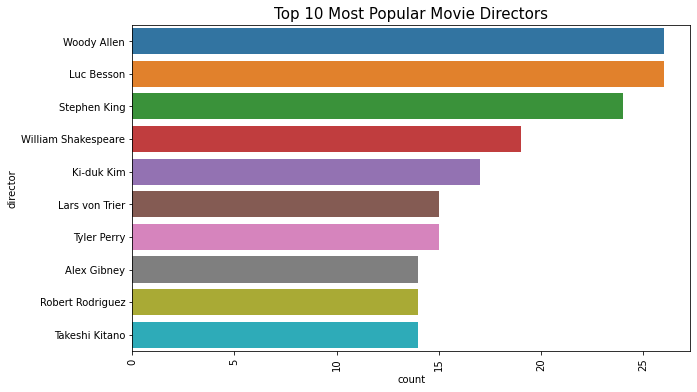

In [19]:
#Plotting top 10 movie directors using a count-plot
plt.figure(figsize = (10,6))
director=df_imdb_copy['director'].explode()
axes=sns.countplot(y=director, order = director.value_counts().index[1:11])
axes.set_title('Top 10 Most Popular Movie Directors',fontsize=15)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

In [20]:
# Top 5 plot keywords by volume:
keywords_df = df_imdb["plot_keywords"].value_counts()
keywords_df.head()

Documentary                         19
f rated                             16
Action                              16
Comedy                              12
stand up special|stand up comedy     9
Name: plot_keywords, dtype: int64

#### Wordcloud of Plot Keywords

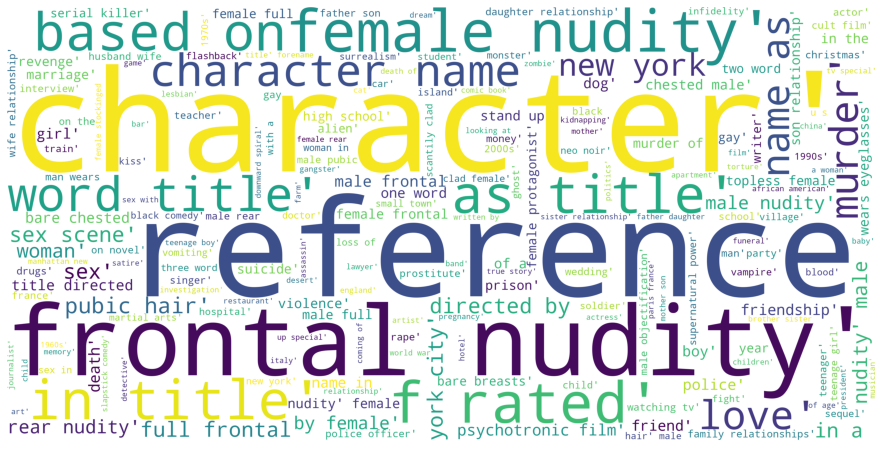

In [26]:
# Creating a wordcloud of the plot_keywords 

df_imdb_copy['plot_keywords']=df_imdb_copy['plot_keywords'].astype('str')

genre_corpus = ' '.join(df_imdb_copy['plot_keywords'])
#Generating the stopwords
stopword = ['nan', 'to', 'genres', 'genre', 'listed']
# Generating the wordcolud
genre_wordcloud = WordCloud(stopwords=stopword, background_color='white', height=2000, width=4000).generate(genre_corpus)
plt.figure(figsize=(16,8))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

#### Runtime Distribution

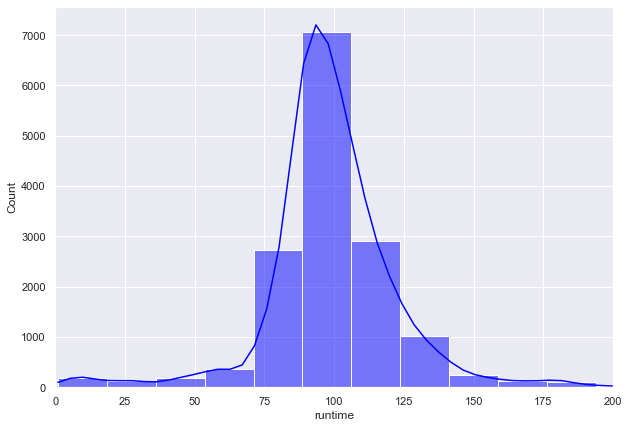

In [55]:

# Plot the genres from most common to least common
sns.set(style="darkgrid")
sns.set(rc = {'figure.figsize':(10,7)})
sns.histplot(data=df_imdb, x="runtime", bins=50, kde=True, color='blue')
plt.xlim(0, 200)
plt.show()

From the histogram we observe that movie runtime is normally distributed with average runtime being 100 minutes.

#### Top Longest Movies
We merge the imdb and the movies dataframes to find the longest movies in the dataset.

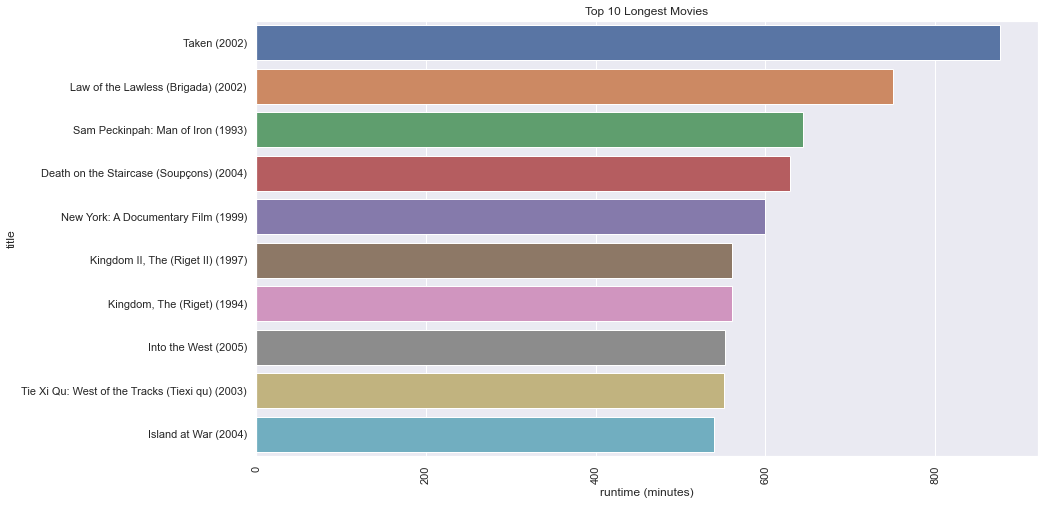

CPU times: total: 266 ms
Wall time: 304 ms


In [9]:
df_movimdb = pd.merge(left=df_movies, right=df_imdb, left_on='movieId', right_on='movieId')
df_movimdb_copy = df_movimdb.copy()
df_movimdb_copy = pd.DataFrame(df_movimdb_copy.sort_values(by=['runtime'],ascending = False))
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(y="title", x="runtime", data=df_movimdb_copy.head(10))
ax.set_title('Top 10 Longest Movies')
ax.set_ylabel('title')
ax.set_xlabel('runtime (minutes)')
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

#### Movies Budget


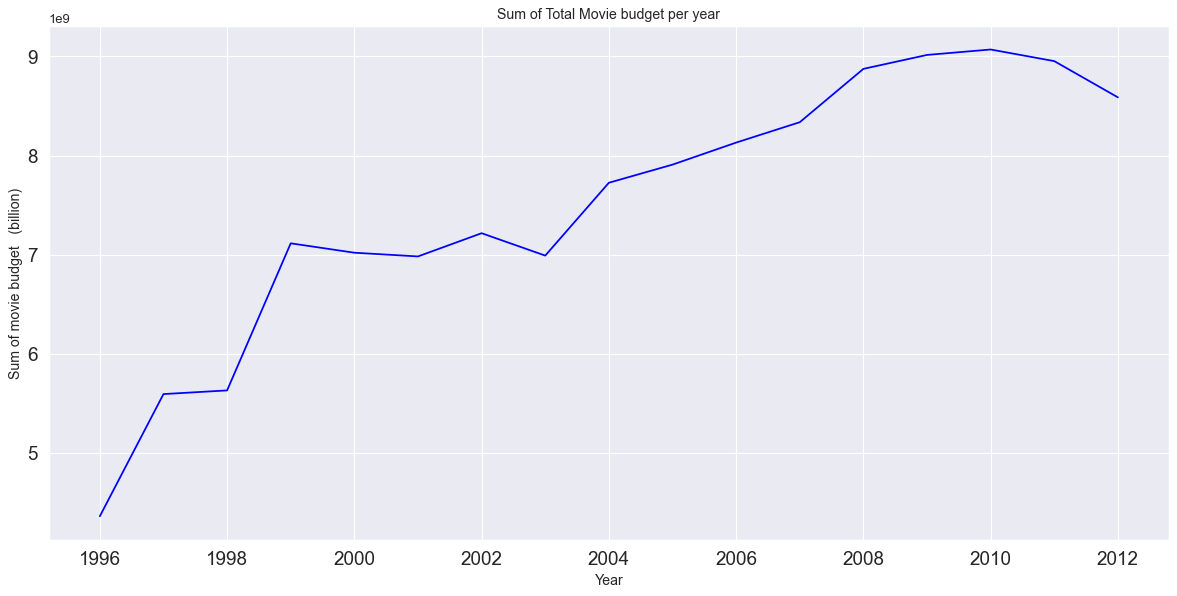

In [11]:

movies_budget = pd.DataFrame(df_movimdb[['movieId', 'title','budget']],columns=['movieId', 'title','budget'])

movies_budget= movies_budget[movies_budget['title'].notnull()]

movies_budget['budget'].replace('', np.nan, inplace=True)
movies_budget.dropna(subset=['budget'], inplace=True)

# Split title seperated by "|" and create a list containing the title allocated to each movie
movies_budget.title = movies_budget.title.apply(lambda x: int(re.findall(r"\d\d\d\d",x).pop(0)))
movies_budget.budget = movies_budget.budget.apply(lambda x: int(re.sub("[^0-9]", "", x)) if str(x)[:1] =='$' else None)
movies_budget = movies_budget[movies_budget['budget'].notnull()]
movies_budget =movies_budget[movies_budget['title'] > 1888]
movies_budget =movies_budget[movies_budget['title'] <= 2021]
movies_budget =movies_budget[movies_budget['title'] > 1995]
movies_budget =movies_budget[movies_budget['title'] <= 2012]
Total_movie_budget = movies_budget.groupby("title")["budget"].sum().reset_index(name="Sum of movie budget")
fig,ax = plt.subplots(figsize=(17, 8), dpi=85)

Total_movie_budget.plot.line(x='title',y='Sum of movie budget', ax=ax, color='blue', 
                             legend=False, fontsize=16)
ax.set_title('Sum of Total Movie budget per year')
ax.set_xlabel('Year')
ax.set_ylabel('Sum of movie budget   (billion)')

plt.show()

We observe that the amount of money spent in movie production per year has increased over the years.

#### Top Budget Movies

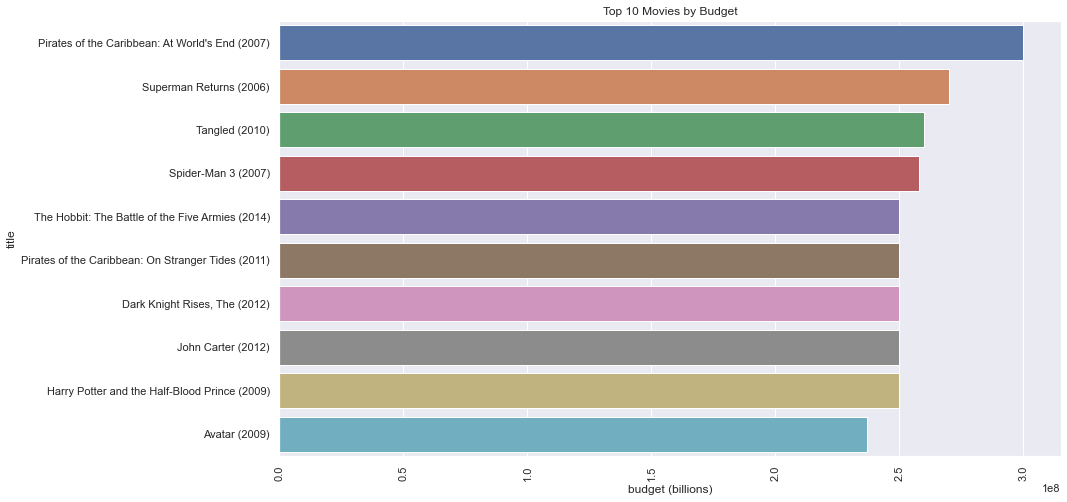

In [12]:
#make a plot which contain top 20 highest budget movies.

df_movimdb_copy = df_movimdb.copy()
df_movimdb_copy.budget = df_movimdb_copy.budget.apply(lambda x: int(re.sub("[^0-9]", "", x)) if str(x)[:1] =='$' else None)
df_movimdb_copy = df_movimdb_copy[df_movimdb_copy['budget'].notnull()]
df_movimdb_copy = pd.DataFrame(df_movimdb_copy.sort_values(by=['budget'],ascending = False))
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(y="title", x="budget", data=df_movimdb_copy.head(10))
ax.set_title('Top 10 Movies by Budget')
ax.set_ylabel('title')
ax.set_xlabel('budget (billions)')
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

<a id='model'></a><br>
## 4. Model Building

[Back to Table of Contents](#Table_Contents)


In this section we construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

We will also create a movie recommender system.

### Content Based Filtering


This system finds the similarity between recommended items based on their description or context. The user’s historical data is taken into account to find products they may like in the future. For instance, if a user likes movies such as ‘The Man From Toronto’ then the system can recommend ‘Kevin Hart's Movies’ or movies with the genre ‘Comedy’.

A drawback of this system is that it tends to return on average items in a similar category with little variation across the recommendations.

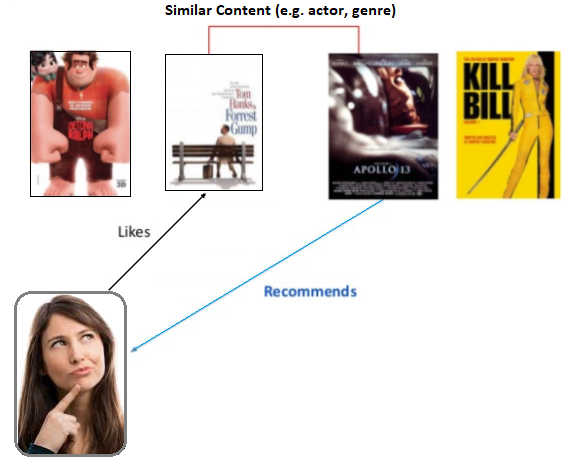

### Collaborative Filtering

Collaborative filtering movie recommender systems are said to be more widely used and make recommendations to users based on the similarity between users, in this case it would be the recommendation of a movie or the likely prediction a user could rate a movie based on the ratings of similar users.

Though they are widely used in the industry, one of the drawbacks of collaborative filtering is the so called **cold start problem** when it comes to new users, as the system does not have sufficient data on the user to make accurate predictions.

Unlike content based methods, collaborative algorithms return more varied results, enabling the business to introduce users to new types of content, hence increasing viewage and profit. 

It is for this reason that we use collaborative filtering as our main approach. 



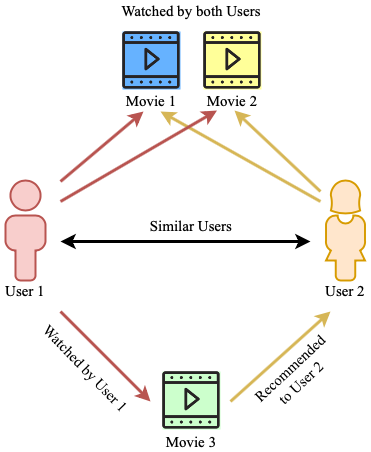

### Similarity Measure

Similarity measure is a real-valued function that quantifies the similarity between two objects. Similarity measure plays a big role when it comes to making recommendation of a movie or predictions of a rating. 

The cosine similarity will be employed in this project.

Mathematically, cosine similarity measures the cosine of the angle between two vectors projected in a multi-dimensional space. The output value ranges from 0–1, 0 means no similarity whereas 1 means that both the items are 100% similar.

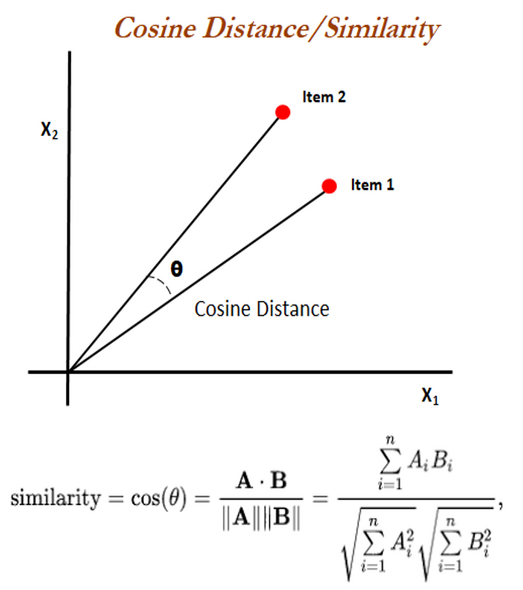

### Recommender System Building

#### Content Based Recommender System
We use the cast, director, plot keywords and genre as the metadata for our content based recommender system. These columns will be combined to form the corpus for each film which will then be used to determine the similarity between films.

In [20]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [19]:
# Creating an empty column and list to store the corpus for each movie
df['corpus'] = ''
corpus = []

# List of the columns we want to use to create our corpus 
columns = ['title_cast', 'director', 'plot_keywords', 'genres']

# For each movie, combine the contents of the selected columns to form it's unique corpus 
for i in range(0, len(df['movieId'])):
    words = ''
    for col in columns:
        words = words + df.iloc[i][col] + " "        
    corpus.append(words)

# Add the corpus information for each movie to the dataframe 
df['corpus'] = corpus
df.set_index('movieId', inplace=True)

# Drop the columns we don't need anymore to preserve memory
df.drop(columns=['title_cast', 'director', 'plot_keywords', 'genres'], inplace=True)

df.head()

NameError: name 'df' is not defined

### Model Selection

We proceed to test a few models and select the best model at predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Surprise or Simple Python RecommendatIon System Engine is a Python SciPy toolkit for building and analysing recommender systems. The tool deals with explicit rating data. With a set of built-in algorithms and datasets Surprise can help you learn how to build recommender systems. It provides various ready-to-use prediction algorithms such as baseline algorithms, neighbourhood methods, matrix factorisation-based such as SVD, PMF, SVD++, NMF and many others


In [ ]:
'''
reader = surprise.Reader(rating_scale = (min_rat,max_rat))
    # Loading the data frame using surprice
    data_load = surprise.Dataset.load_from_df(ratings, reader)
    # Insatntiating surpricce
    method = SVD(n_factors = 200 , lr_all = 0.005 , reg_all = 0.02 , n_epochs = 40 , init_std_dev = 0.05)
    # Loading a trainset into the model
    model = method.fit(data_load.build_full_trainset())
'''

In [9]:

df_train.drop(df_train.index[df_train['userId'] == 72315], inplace=True)

df_train = df_train.reset_index(drop=True)

In [10]:
df_train.shape

(9987086, 4)

In [11]:
data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], Reader())

In [4]:
train_set, test_set = train_test_split(data, test_size=0.2)

In [15]:
#allows us to train on the whole dataset
trainset = data.build_full_trainset()
#svd=SVD(n_factors = 200, n_epochs = 30, init_std_dev=0.02)
svd=SVD(n_epochs = 50, n_factors = 400, init_std_dev = 0.001, random_state=42)
#svd = SVD(n_factors = 300 , lr_all = 0.006 , reg_all = 0.04 , n_epochs = 60 , init_std_dev = 0.04)
# Base Model
#svd = SVD()
svd.fit(train_set)

In [16]:
import pickle
with open('model_pkl', 'wb') as files:
    pickle.dump(svd, files)

In [18]:
# Make predictions
test_pred= svd.test(test_set)
#Evaluate model performance
print(accuracy.rmse(test_pred,verbose=True))

RMSE: 0.8061
0.8060633196574961


In [19]:
# Dictionary for the data to log for SVD model
params = {'model_name': 'SVD'}
metrics = {'RMSE': accuracy.rmse(test_pred)}

# Log the parameters and results for the SVD model
experiment.log_parameters(params)
experiment.log_parameters(metrics)
# End the experiment for the SVD experiment
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary


RMSE: 0.8061


COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/roceey/movie-recommendation-edsa-teamzf1/a55aaa1a03fd4423b23d5317528a6fe7
COMET INFO:   Parameters:
COMET INFO:     RMSE       : 0.8060633196574961
COMET INFO:     model_name : SVD
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (10.89 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after 

## Hyperparameter Tuning 
 
Hyperparameter tuning is the process of determining the right combination of hyperparameters that allows the model to maximize model performance. Setting the correct combination of hyperparameters is the only way to extract the maximum performance out of models.

We hypertune the SVD algorithm model as follows


In [ ]:
# Define search grid
param_grid = {'n_epochs': [30, 40, 50], 'init_std_dev' : [0.01,0.02,0.05], 'n_factors' : [200,300,400]}

# Instatiate gridsearch instance
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=2)

# Run gridsearch
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


In [ ]:
#svd=SVD(n_epochs = 50, n_factors = 250, init_std_dev = 0.05, random_state=42)
#svd.fit(train_set)

### Data Engineering 

After our EDA discovery of an outlier in the Users data, we remove that user and rerun the SVD model to see if we can improve on the RMSE 


In [5]:
# Drop User 72315 
df_train.drop(df_train.index[df_train['userId'] == 72315], inplace=True)

df_train = df_train.reset_index(drop=True)

reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], reader)

In [4]:
# Train the model using trimmed data
trainset = data.build_full_trainset()

#SVD algorithm.
algo = SVD(n_epochs = 50, n_factors = 400, init_std_dev = 0.001, random_state=42)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

### Submission 

In [5]:


df_test.loc[:, 'rating'] = 0


#using load_from_df surprise function to load dataset for predictions
test_processed = Dataset.load_from_df(df_test[['userId','movieId','rating']], reader)

#Train test split, test size will be equal to 1.
NA, test = train_test_split(test_processed, test_size=1.0, shuffle = False, random_state = 42)

#Prediction 
predictions = algo.test(test)

#saving the predictions as a list to add as a column for our Kaggle submission
ratings = [i.est for i in predictions]
ratings

[2.9883400198393604,
 4.160714982105501,
 3.775221235831801,
 4.12183688752379,
 2.7602468587318656,
 3.880230651791303,
 3.9370872896534648,
 3.902909832376966,
 3.0841501366875654,
 3.893565534050158,
 3.099807959583395,
 2.955689041855998,
 4.29464995594231,
 5,
 4.3324597517887895,
 4.033631950440839,
 3.6761728167393666,
 2.7649787082266726,
 3.7448740358198,
 3.8622169652608918,
 4.192232954259439,
 3.595877021803325,
 3.1765281289558547,
 3.00259724121215,
 3.583055539361022,
 3.7773858152215536,
 4.21674378381287,
 3.3438873879040294,
 3.7176211712342813,
 3.504771268357312,
 4.351670678534013,
 2.917351015870854,
 3.396040715445594,
 3.2904534150573364,
 2.7328834799716435,
 3.7758792941267934,
 3.467116261810531,
 3.477468531930672,
 5,
 3.2817464131145546,
 4.443336181794563,
 3.303008389002215,
 4.193439035100696,
 3.7825896220858124,
 4.9106678601015865,
 3.5091711820001827,
 4.102198100386605,
 4.661323312067926,
 3.719487745954835,
 4.405916462522201,
 3.9660792202859203

In [7]:
display(df_sample_submission.head())
df_test['Id'] = df_test['userId'].astype(str)  + '_'+ df_test['movieId'].astype(str) 
df_test
#change rating column
df_test['rating'] = ratings
del df_test['userId']
del df_test['movieId']
display(df_test)

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


,rating,Id
0,2.988340,1_2011
1,4.160715,1_4144
2,3.775221,1_5767
3,4.121837,1_6711
4,2.760247,1_7318
...,...,...
5000014,3.611854,162541_4079
5000015,3.806026,162541_4467
5000016,2.660416,162541_4980
5000017,2.838283,162541_5689


In [8]:
df_test['R'] = df_test['rating']
del df_test['rating']
df_test['rating'] = df_test['R']
del df_test['R']
df_test

,Id,rating
0,1_2011,2.988340
1,1_4144,4.160715
2,1_5767,3.775221
3,1_6711,4.121837
4,1_7318,2.760247
...,...,...
5000014,162541_4079,3.611854
5000015,162541_4467,3.806026
5000016,162541_4980,2.660416
5000017,162541_5689,2.838283


In [10]:
df_test.to_csv('submission.csv', index = False)